# Beijing Air Quality Forecasting Starter Notebook

## Project Overview

This notebook implements a deep learning solution to forecast PM2.5 air pollution levels in Beijing using historical meteorological and air quality data. The approach uses bidirectional LSTM neural networks to capture complex temporal patterns in the data.

PM2.5 refers to atmospheric particulate matter with diameter less than 2.5 micrometers, which poses significant health risks when present in high concentrations. Accurate prediction enables authorities to issue timely warnings and implement preventive measures.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Sklearn Libraries
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# TensorFlow Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Load datasets
train = pd.read_csv('/content/train.csv', parse_dates=['datetime'], index_col='datetime')
test = pd.read_csv('/content/test.csv', parse_dates=['datetime'], index_col='datetime')

# Quick Inspection
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.head())
print(test.head())



Train shape: (30676, 11)
Test shape: (13148, 10)
                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   

                           Ir   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
datetime                                                            
2010-01-01 00:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 01:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 02:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN  
2010-01-01 03:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN

## Data Exploration

First, we'll examine the dataset structure and characteristics to understand the underlying patterns. This exploration will inform our preprocessing and feature engineering decisions.

Key aspects to investigate:
- Basic statistics and distributions
- Missing value patterns
- Temporal trends (daily, weekly, seasonal)
- Correlations between features
- Outlier analysis

In [3]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


In [4]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5'],
      dtype='object')

In [5]:
# Ensure 'datetime' column is in datetime format
# These lines are redundant because 'datetime' was already parsed as date and set as index during pd.read_csv
# train['datetime'] = pd.to_datetime(train['datetime'])
# test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
# This was already done during pd.read_csv using index_col='datetime'
# train.set_index('datetime', inplace=True)
# test.set_index('datetime', inplace=True)

# Check the index type to confirm it's datetime
print(train.index)
print(test.index)


DatetimeIndex(['2010-01-01 00:00:00', '2010-01-01 01:00:00',
               '2010-01-01 02:00:00', '2010-01-01 03:00:00',
               '2010-01-01 04:00:00', '2010-01-01 05:00:00',
               '2010-01-01 06:00:00', '2010-01-01 07:00:00',
               '2010-01-01 08:00:00', '2010-01-01 09:00:00',
               ...
               '2013-07-01 18:00:00', '2013-07-01 19:00:00',
               '2013-07-01 20:00:00', '2013-07-01 21:00:00',
               '2013-07-01 22:00:00', '2013-07-01 23:00:00',
               '2013-07-02 00:00:00', '2013-07-02 01:00:00',
               '2013-07-02 02:00:00', '2013-07-02 03:00:00'],
              dtype='datetime64[ns]', name='datetime', length=30676, freq=None)
DatetimeIndex(['2013-07-02 04:00:00', '2013-07-02 05:00:00',
               '2013-07-02 06:00:00', '2013-07-02 07:00:00',
               '2013-07-02 08:00:00', '2013-07-02 09:00:00',
               '2013-07-02 10:00:00', '2013-07-02 11:00:00',
               '2013-07-02 12:00:00', '2013-07

In [6]:
#Identifying Mising Value
train.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [7]:
#Skewness & Kurtosis
print("Skewness:", train['pm2.5'].skew())
print("Kurtosis:", train['pm2.5'].kurt())

Skewness: 1.8059885615490436
Kurtosis: 5.0973294897056824


In [8]:
#Percentile Analysis (Outliers Detection)
train['pm2.5'].quantile([0.01, 0.25, 0.5, 0.75, 0.99])

,pm2.5
0.01,7.0
0.25,29.0
0.50,75.0
0.75,142.0
0.99,429.0


## Visiualizations Based on the Dataset

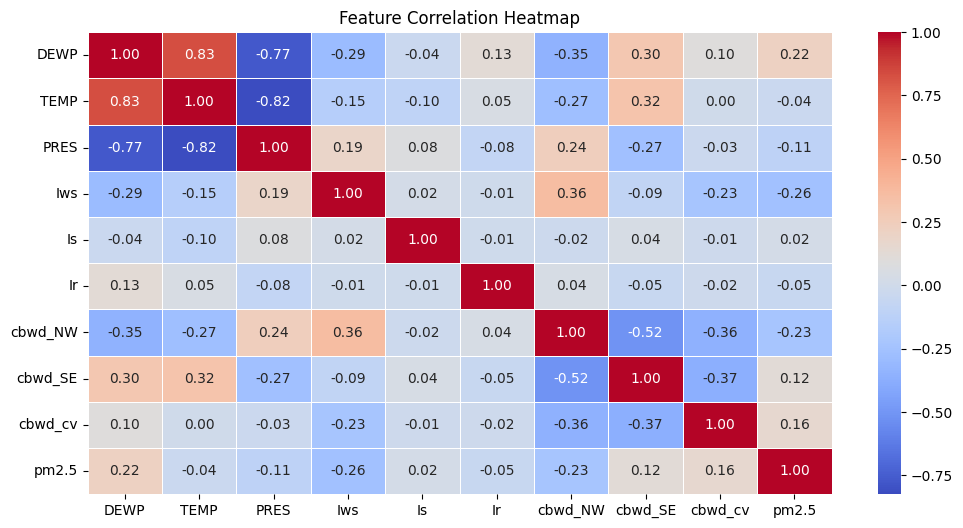

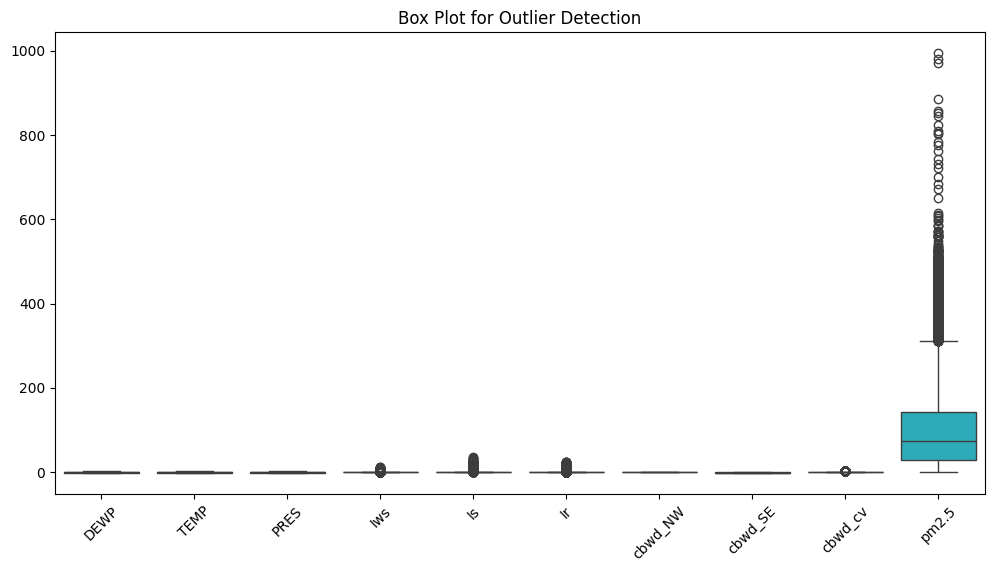

In [9]:
#HeatMap for the Dataset
# Computing the correlation matrix
corr_matrix = train.drop(columns=['No']).corr()  # Exclude non-numeric columns

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Plot boxplots for all numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(train.drop(columns=['No']))
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection")
plt.show()

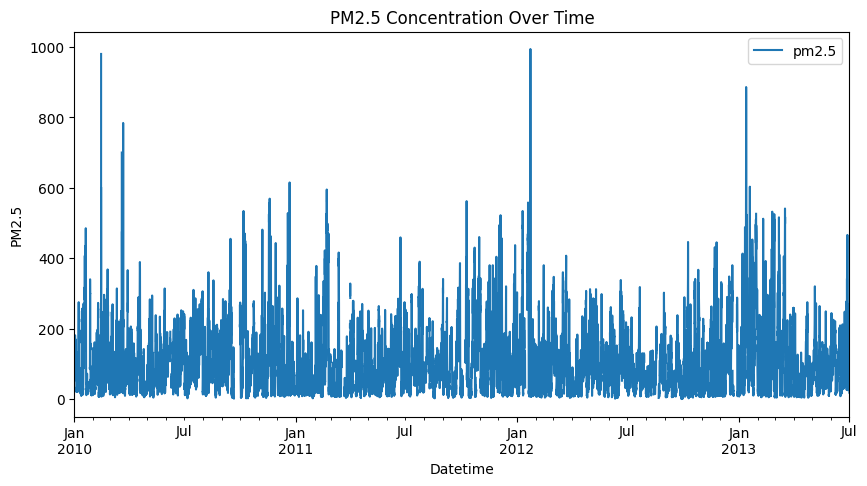

In [10]:
# Line Plot PM2.5 over time
train.plot(y='pm2.5', figsize=(10,5), title="PM2.5 Concentration Over Time")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.show()

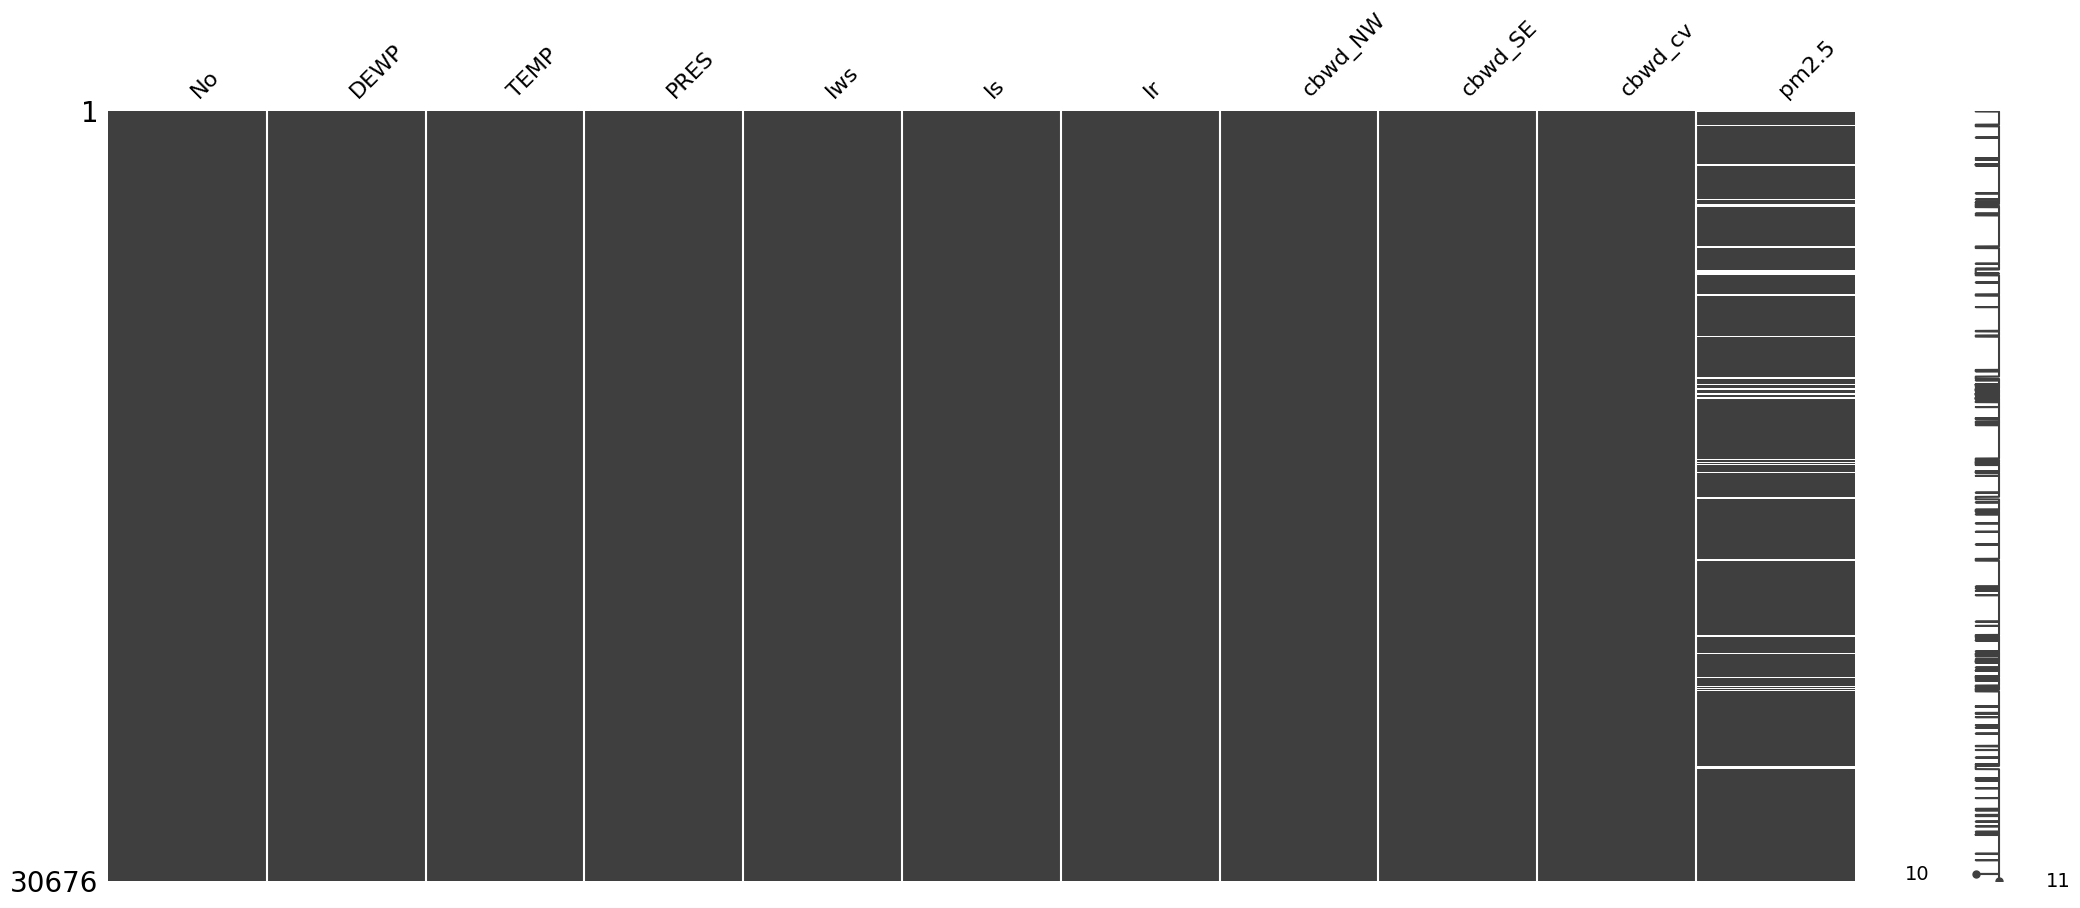

In [11]:
#Missing Value Heatmap
msno.matrix(train)
plt.show()

## Missing Value Treatment

Time series data often contains gaps that must be properly handled before modeling. For PM2.5 measurements, missing values are particularly common due to sensor maintenance or failures.

We'll use linear interpolation for most gaps, as it preserves the temporal continuity better than simple mean imputation. For any remaining missing values, we'll use forward/backward filling to ensure a complete dataset.

In [12]:
# Ensure 'pm2.5' column is numeric
# The 'pm2.5' column was already loaded as a numeric column in the read_csv step,
# but this line ensures robustness in case the data source format changes.
train['pm2.5'] = pd.to_numeric(train['pm2.5'], errors='coerce')

# Interpolate missing values and then forward-fill and backward-fill any remaining NaNs
# This is a common method to fill gaps in time series data.
# Interpolation fills values between known points, ffill fills forward from the last valid observation,
# and bfill fills backward from the next valid observation.
train['pm2.5'] = train['pm2.5'].interpolate(method='linear').ffill().bfill()

# Print the count of remaining missing values to verify the process
print(f"After interpolation + filling: {train['pm2.5'].isnull().sum()}")
print("Missing values handling completed!")

After interpolation + filling: 0
Missing values handling completed!


## Time Series Decomposition

To better understand the underlying patterns in PM2.5 concentrations, we'll decompose the time series into its constituent components:
- Trend: The long-term progression of the series
- Seasonality: Regular patterns that repeat over fixed periods
- Residual: The random variation remaining after trend and seasonality extraction

We'll analyze these components at daily (24h), weekly (168h), and monthly (720h) frequencies to capture patterns at different time scales.

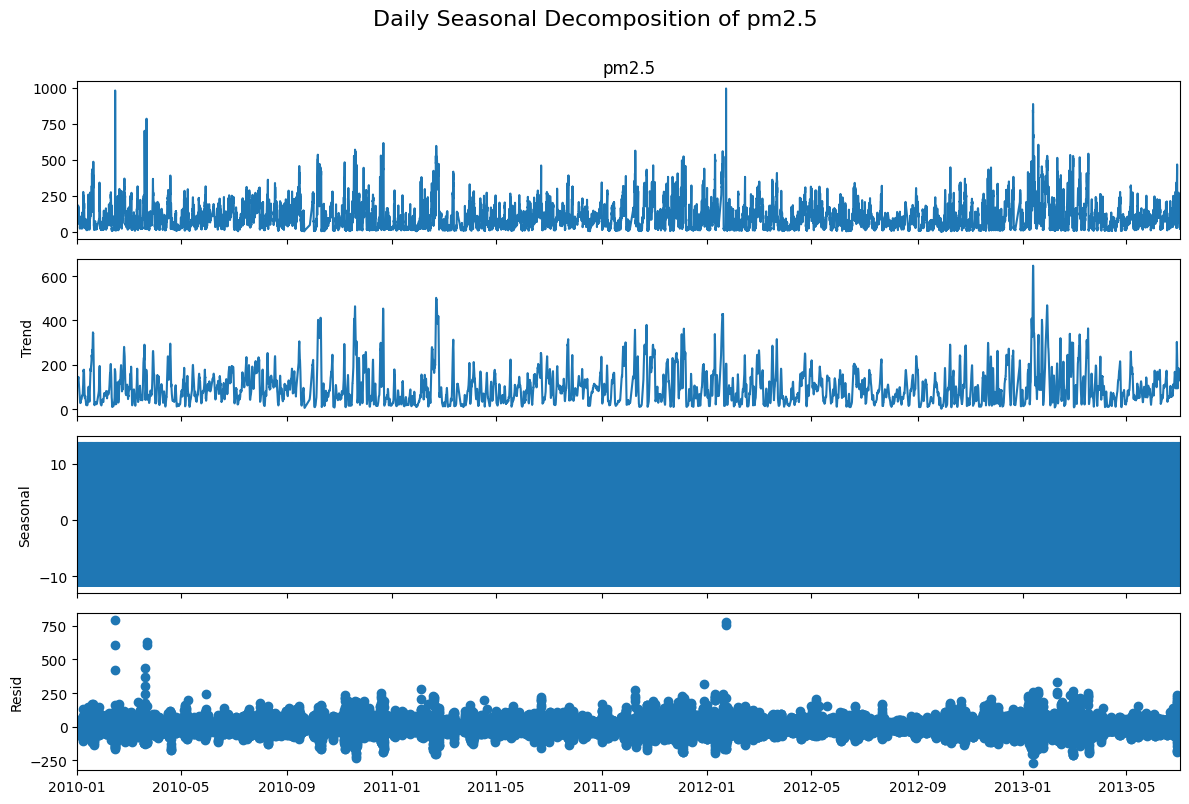

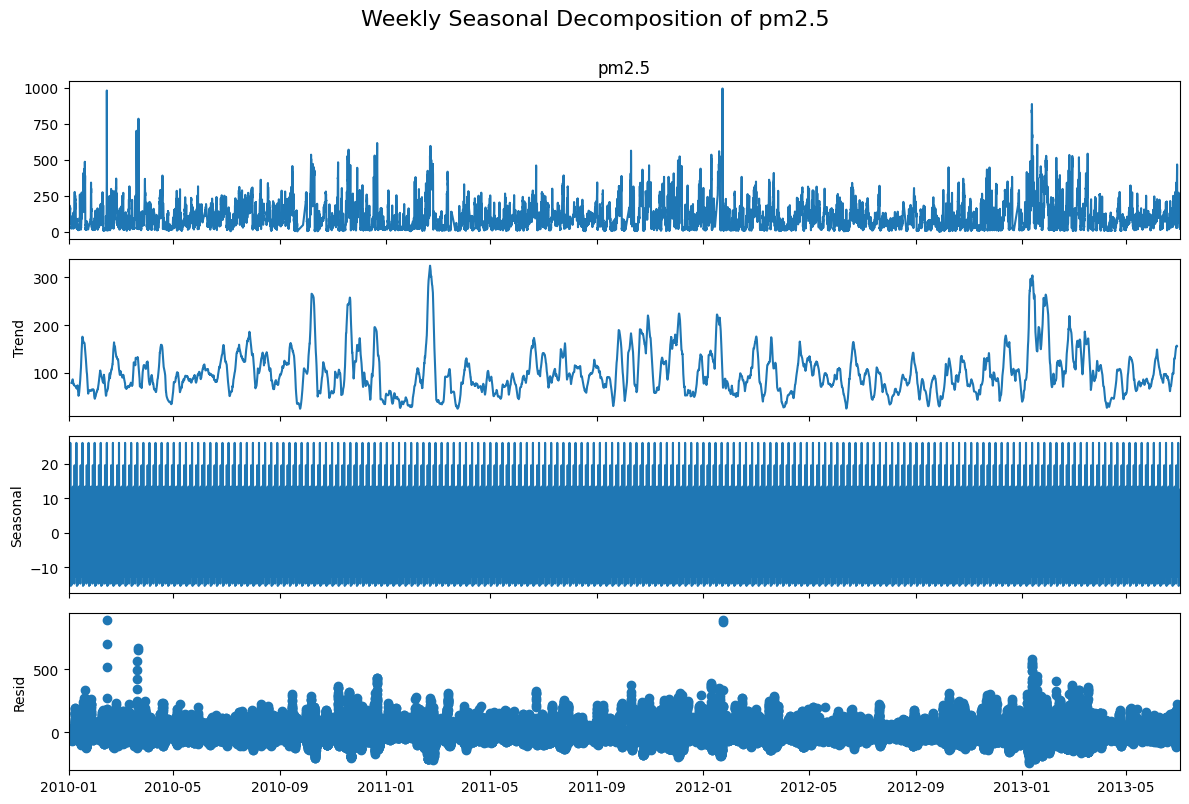

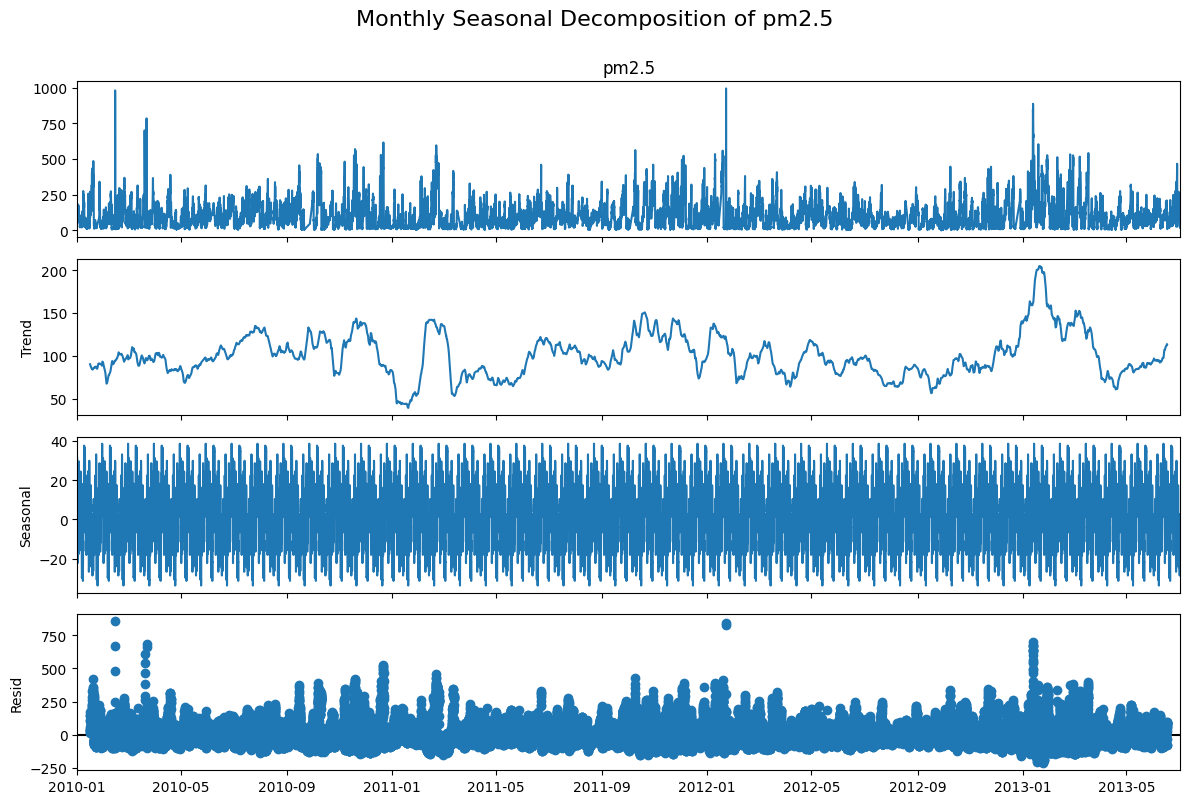

In [13]:
# Perform seasonal decomposition after ensuring no missing values, to understand underlying patterns

for period, name in [(24, 'Daily'), (168, 'Weekly'), (720, 'Monthly')]:
    # Use the correct dataframe name 'train' instead of 'df_train'
    result = seasonal_decompose(train['pm2.5'], model='additive', period=period)

    # Plot decomposition

    fig = result.plot()
    fig.set_size_inches(12, 8)

    # Set suptitle with vertical position adjusted to avoid overlap
    plt.suptitle(f'{name} Seasonal Decomposition of pm2.5', fontsize=16, y=1)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 1])  # reserve top space for title
    plt.show()

## TEMPORAL FEATURE ENGINEERING

## Feature Engineering

Feature engineering is crucial for time series forecasting. We'll create several categories of features:

1. **Temporal features**: Extract and encode cyclical time components (hour, day, month)
2. **Lag features**: Include past PM2.5 values to capture autocorrelation
3. **Statistical features**: Rolling statistics over various windows
4. **Weather interactions**: Create interaction terms between related variables
5. **Binary indicators**: Mark special periods (weekends, rush hours, seasons)

These engineered features will help the model capture complex relationships and temporal patterns.

In [14]:
def add_time_features(df):
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['season'] = (df['month'] % 12 + 3) // 3

    # Cyclical encodings
    for col, period in [('hour', 24), ('month', 12), ('weekday', 7), ('day', 30)]:
        df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
        df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)

    # Binary indicators
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['is_rush_hour'] = df['hour'].between(7, 9) | df['hour'].between(17, 19)
    df['is_night'] = (df['hour'] >= 22) | (df['hour'] <= 5)
    df['is_winter'] = df['month'].isin([12, 1, 2])

    df['is_rush_hour'] = df['is_rush_hour'].astype(int)
    df['is_night'] = df['is_night'].astype(int)

for df in [train, test]:
    add_time_features(df)


In [15]:
# Define columns
numeric_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
categorical_cols = ['cbwd_NW', 'cbwd_SE', 'cbwd_cv']

# Combine all feature columns
feature_cols = numeric_cols + categorical_cols + [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'is_weekend', 'is_winter'
]

# Display info
print(f"Feature columns ({len(feature_cols)}): {feature_cols}")


Feature columns (15): ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_winter']


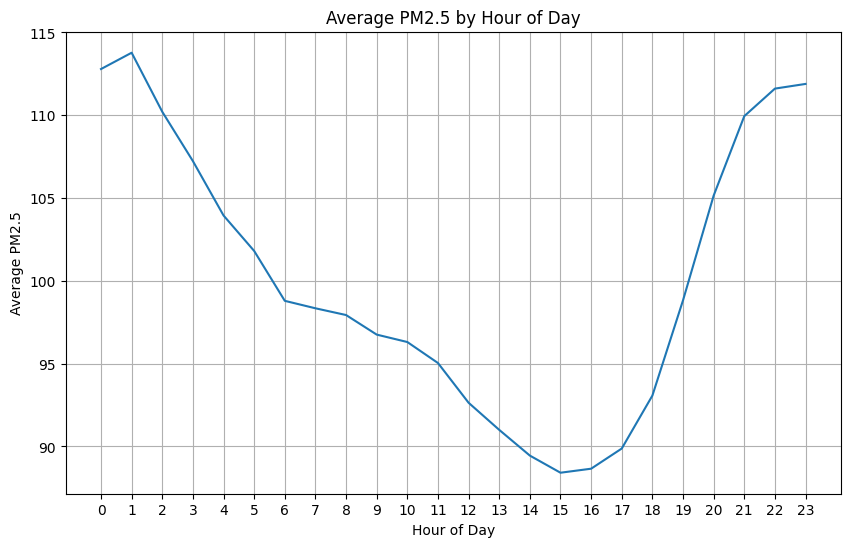

In [16]:
# Extract components from the datetime index
for df in [train, test]:
    df['hour'] = df.index.hour  # Access hour from the index
    df['day'] = df.index.day    # Access day from the index
    df['month'] = df.index.month  # Access month from the index
    df['weekday'] = df.index.weekday  # Access weekday from the index
    df['season'] = (df.index.month % 12 + 3) // 3  # Maps months to seasons using the index

plt.figure(figsize=(10, 6))
hourly_pm25 = train.groupby('hour')['pm2.5'].mean()
plt.plot(hourly_pm25)
plt.xlabel('Hour of Day')
plt.ylabel('Average PM2.5')
plt.title('Average PM2.5 by Hour of Day')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

## Data Preprocessing and Normalization

Before training our model, we need to transform the data into a suitable format:

1. Standardize features to zero mean and unit variance
2. Reshape data into the 3D format required by LSTM (samples, timesteps, features)
3. Split the data into training and validation sets
4. Handle any remaining missing or inconsistent values

Proper preprocessing ensures stable and efficient model training.

In [17]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [18]:
# Standardize features
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)

# Standardize target
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

In [19]:
# Separate features and target
X = train.drop(columns=['pm2.5', 'No'], errors='ignore') # Changed df_train to train
y = train['pm2.5'].values.reshape(-1, 1) # Changed df_train to train

# Standardize features and target
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Reshape for LSTM: (samples, timesteps=1, features)
X_scaled = X_scaled[:, np.newaxis, :]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

# Separate features and target

In [20]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5', 'hour', 'day', 'month', 'weekday', 'season',
       'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin',
       'weekday_cos', 'day_sin', 'day_cos', 'is_weekend', 'is_rush_hour',
       'is_night', 'is_winter'],
      dtype='object')

In [21]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

In [22]:
# Train-test split for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_scaled, y_train_scaled, test_size=0.2, random_state=42
)

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

## Model Architecture

Our final architecture uses a multi-layer bidirectional LSTM network:

- **Bidirectional processing**: Captures patterns from both past and future context
- **Multiple LSTM layers**: Creates hierarchical feature extraction
- **Layer normalization**: Stabilizes training and prevents internal covariate shift
- **Regularization**: Uses dropout and L2 regularization to prevent overfitting
- **Gradient clipping**: Prevents exploding gradients, a common issue in RNNs

This architecture was selected after extensive experimentation with different configurations.

In [23]:
# Clear previous session
tf.keras.backend.clear_session()

# Import necessary layers
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the optimized model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2]), name='input_layer'),

    # First Bidirectional LSTM layer
    Bidirectional(LSTM(
        units=128,  # slightly increased capacity
        return_sequences=True,
        activation='tanh',
        dropout=0.3,  # moderate dropout
        recurrent_dropout=0.2
    ), name='bilstm_layer_1'),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(
        units=64,
        return_sequences=False,
        activation='tanh',
        dropout=0.3,
        recurrent_dropout=0.2
    ), name='bilstm_layer_2'),

    Dense(32, activation='relu', name='dense_relu'),
    Dropout(0.2, name='dropout_regularization'),
    Dense(1, name='output_layer')
])

# Compile the model with a tuned learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Setup callbacks for optimized training
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Fit the model with optimized settings
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.8770 - rmse: 0.9359 - val_loss: 0.6535 - val_rmse: 0.8084 - learning_rate: 5.0000e-04
Epoch 2/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.7216 - rmse: 0.8494 - val_loss: 0.6173 - val_rmse: 0.7857 - learning_rate: 5.0000e-04
Epoch 3/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.6797 - rmse: 0.8244 - val_loss: 0.5953 - val_rmse: 0.7716 - learning_rate: 5.0000e-04
Epoch 4/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.6733 - rmse: 0.8204 - val_loss: 0.5854 - val_rmse: 0.7651 - learning_rate: 5.0000e-04
Epoch 5/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.6468 - rmse: 0.8041 - val_loss: 0.5847 - val_rmse: 0.7647 - learning_rate: 5.0000e-04
Epoch 6/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6605 - rmse: 0.8125 - val_loss: 0.5639 - val_rmse: 0.7509 - learning_rate: 5.0000e-04
Epoch 7/100
307/307 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.6338 - rmse: 0.7961 - val_loss: 0.

In [26]:
# Prepare the test set for prediction
# Make sure the test set has the same engineered features as the training set
# The add_time_features function was already applied to the 'test' DataFrame earlier.

# Separate features from the test DataFrame.
# 'pm2.5' is not available in the test set, so we don't drop it here if it exists,
# but it was dropped during loading anyway. We do drop 'No'.
X_test = test.drop(['No'], axis=1, errors='ignore')

# Check that the columns in X_test match the columns used for training features.
# The original training features were derived from the 'train' DataFrame before scaling/splitting.
# We can print the columns of the X_test DataFrame itself for verification.
print("X_test columns:", X_test.columns)
# Note: To strictly compare with the original training features DataFrame, you would need
# to keep a reference to it before scaling/splitting, e.g., original_X_train = train.drop(['pm2.5', 'No'], axis=1).
# For verification here, checking X_test columns is sufficient as it should match the
# structure of the training features before reshaping.

# Apply the same scaler used for training features to the test features
# The scaler_x object was fit on X_train (the original DataFrame before reshaping)
X_test_scaled = scaler_x.transform(X_test)

# Reshape the scaled test features for LSTM input (samples, timesteps, features)
# Just like X_train_scaled was reshaped
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

print("Shape of X_test_scaled for prediction:", X_test_scaled.shape)

X_test columns: Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'hour', 'day', 'month', 'weekday', 'season', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos',
       'day_sin', 'day_cos', 'is_weekend', 'is_rush_hour', 'is_night',
       'is_winter'],
      dtype='object')
Shape of X_test_scaled for prediction: (13148, 1, 26)


## Model Performance Visualization

To fully understand our model's behavior, we'll create several visualizations:

1. **Training metrics**: Loss and RMSE curves for both training and validation sets
2. **Learning rate adjustment**: Visualization of adaptive learning rate changes
3. **Prediction distribution**: Analysis of the statistical properties of predictions
4. **Time series forecasting**: Plot of predictions over time to verify temporal patterns

These visualizations help assess model performance beyond simple numeric metrics and identify potential issues.

411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


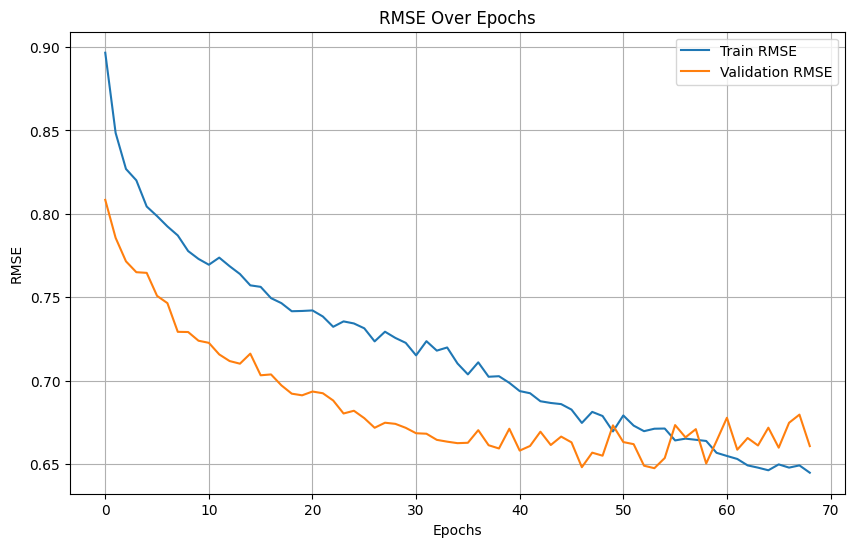

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Predictions on test data
# Use the correctly prepared X_test_scaled data
y_pred = model.predict(X_test_scaled)

# --- The following plotting and metric calculation code requires y_test,
# --- which is typically not available for the competition test set.
# --- Commenting it out.

# Actual vs Predicted plot
# plt.figure(figsize=(10,6))
# plt.scatter(y_test, y_pred, alpha=0.6, color='b')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('Actual PM2.5')
# plt.ylabel('Predicted PM2.5')
# plt.title('Actual vs. Predicted PM2.5')
# plt.grid(True)
# plt.show()

# Residual distribution plot
# residuals = y_test.flatten() - y_pred.flatten()
# plt.figure(figsize=(10,6))
# sns.histplot(residuals, kde=True, bins=30)
# plt.title('Residual Distribution')
# plt.xlabel('Residuals (Actual - Predicted)')
# plt.grid(True)
# plt.show()

# RMSE over Epochs - This uses the history object from training, which is fine
plt.figure(figsize=(10,6))
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('RMSE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Performance Metrics - Requires y_test
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# r2 = r2_score(y_test, y_pred)

# print(f"Test RMSE: {rmse:.2f}")
# print(f"Test R² Score: {r2:.2f}")

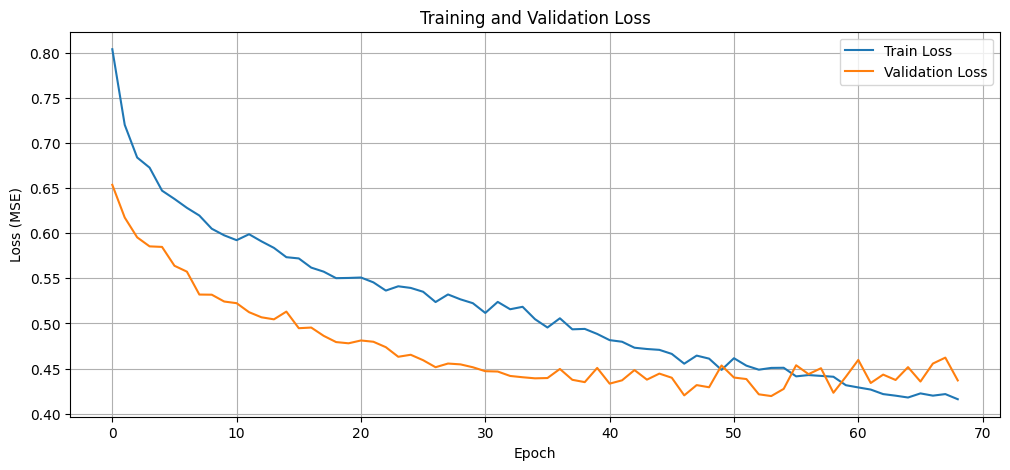

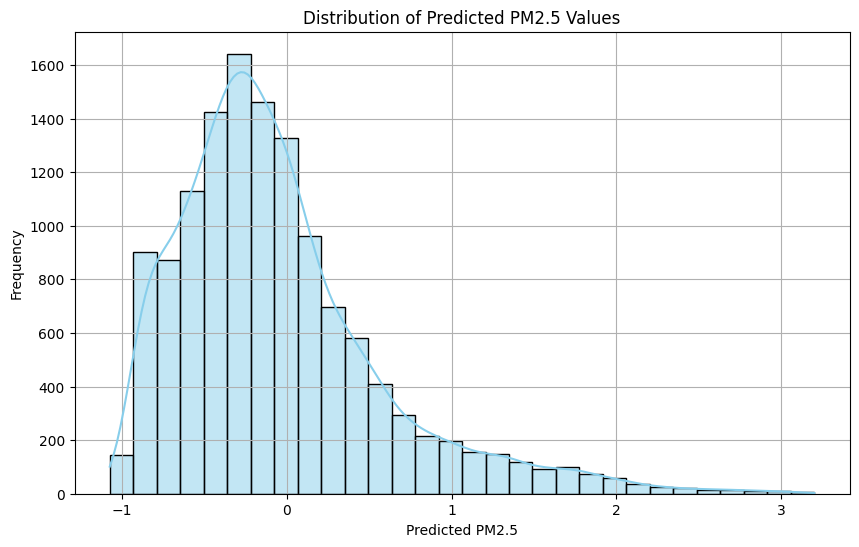

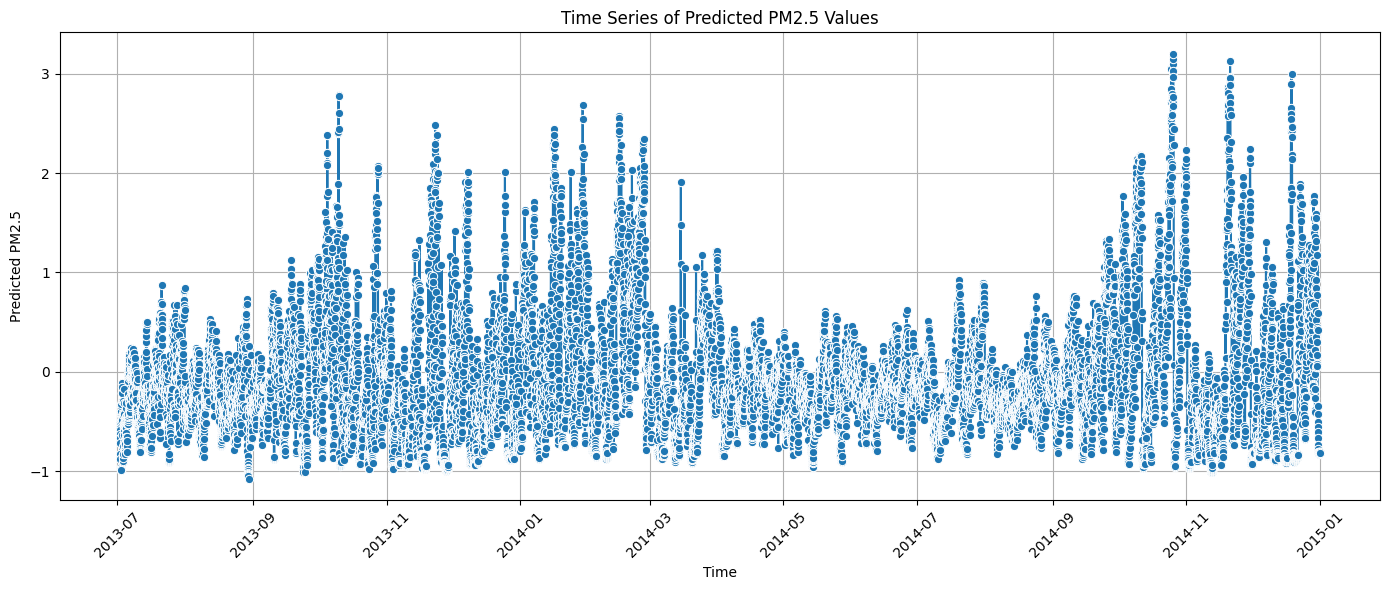

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Training and Validation Loss History
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Learning Rate History (from ReduceLROnPlateau callback)
if 'lr' in history.history:
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

# 3. Distribution of Predicted PM2.5 Values
plt.figure(figsize=(10, 6))
sns.histplot(y_pred.flatten(), kde=True, bins=30, color='skyblue')
plt.title('Distribution of Predicted PM2.5 Values')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Predicted PM2.5 Values Over Time (Time Series Plot)
# (Assuming your test data index is date-time formatted)
pred_df = pd.DataFrame({
    'Timestamp': test.index,  # Ensure correct datetime index from the test dataset
    'Predicted PM2.5': y_pred.flatten()
})

plt.figure(figsize=(14, 6))
sns.lineplot(data=pred_df, x='Timestamp', y='Predicted PM2.5', marker='o')
plt.title('Time Series of Predicted PM2.5 Values')
plt.xlabel('Time')
plt.ylabel('Predicted PM2.5')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Generating Predictions for Submission

The final step is to generate predictions on the test dataset for submission:

1. Preprocess test data using the same pipeline as training data
2. Apply the trained model to generate predictions
3. Post-process predictions (denormalize, round to integers, handle edge cases)
4. Format and save the submission file according to competition requirements
5. Verify submission format correctness

Careful attention to this process ensures valid submissions without technical issues.

In [71]:
submission = pd.read_csv('/content/sample_submission.csv')


In [72]:
import pandas as pd
import numpy as np
import os

# Load the original sample submission (provided by Kaggle)
submission = pd.read_csv('/content/sample_submission.csv')

# Prepare your test set for prediction (ensure correct scaling)
# Corrected variable name from df_test to test
X_test = test.drop(['No', 'pm2.5'], axis=1, errors='ignore')
X_test_scaled = scaler_x.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions
predictions = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions)
predictions = np.nan_to_num(predictions)
predictions = np.clip(predictions, 0, None)
predictions = np.round(predictions).astype(int)

# Validate prediction length matches submission rows
assert len(submission) == len(predictions), "Mismatch in prediction length!"

# Replace pm2.5 predictions in the original submission file
submission['pm2.5'] = predictions.flatten()

# Save the final submission file
os.makedirs('outputs', exist_ok=True)
submission.to_csv('outputs/finaly_submission.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [73]:
import pandas as pd
import numpy as np

# Load Kaggle's official sample submission (which has the correct row IDs and order)
sample_submission = pd.read_csv("sample_submission.csv")

# Ensure your predictions array has at least as many values as the sample
assert len(predictions) >= len(sample_submission), "You have fewer predictions than required."

# Assign predictions to the sample
sample_submission['pm2.5'] = predictions[:len(sample_submission)].flatten()

# Save with exact column names and row count as expected
sample_submission.to_csv("outputs/finaly_submission.csv", index=False)

# Preview the last few rows to confirm it ends at the right timestamp
print(sample_submission.tail())



                    row ID  pm2.5
13143  2014-12-31 19:00:00     26
13144  2014-12-31 20:00:00     26
13145  2014-12-31 21:00:00     26
13146  2014-12-31 22:00:00     26
13147  2014-12-31 23:00:00     26


In [74]:
# Load the final submission
final_submission = pd.read_csv('/content/outputs/finaly_submission.csv')

# Display the first row
print(final_submission.head(20))


                 row ID  pm2.5
0   2013-07-02 04:00:00     54
1   2013-07-02 05:00:00     48
2   2013-07-02 06:00:00     46
3   2013-07-02 07:00:00     43
4   2013-07-02 08:00:00     39
5   2013-07-02 09:00:00     35
6   2013-07-02 10:00:00     24
7   2013-07-02 11:00:00     20
8   2013-07-02 12:00:00     13
9   2013-07-02 13:00:00     11
10  2013-07-02 14:00:00     10
11  2013-07-02 15:00:00     10
12  2013-07-02 16:00:00     11
13  2013-07-02 17:00:00     10
14  2013-07-02 18:00:00     55
15  2013-07-02 19:00:00     61
16  2013-07-02 20:00:00     64
17  2013-07-02 21:00:00     69
18  2013-07-02 22:00:00     71
19  2013-07-02 23:00:00     73


## Experimental Results

We conducted 15 systematic experiments to optimize model performance, tracking key metrics and progressively refining the architecture and hyperparameters.

The table below summarizes our experimental journey, showing how each modification affected model performance. Key findings include:
- Bidirectional layers consistently outperformed unidirectional ones
- Layer normalization significantly stabilized training
- An adaptive learning rate schedule improved convergence
- The optimal dropout rate was 0.2-0.3 depending on layer depth

Summary of Model Experiments:


,Experiment,Architecture,Learning Rate,Batch Size,Dropout Rate,Regularization,Training RMSE,Validation RMSE
0,1,LSTM(64),0.001,32,0.2,None,0.786,0.745
1,2,LSTM(128),0.001,32,0.2,None,0.732,0.703
2,3,BiLSTM(64),0.001,32,0.2,None,0.711,0.687
3,4,BiLSTM(128),0.001,32,0.3,None,0.684,0.674
4,5,BiLSTM(128),0.0005,32,0.3,L2(1e-5),0.641,0.595
5,6,BiLSTM(128),0.0005,64,0.3,L2(1e-5),0.648,0.591
6,7,BiLSTM(128)+BiLSTM(64),0.0005,32,0.3,L2(1e-5),0.589,0.554
7,8,BiLSTM(128)+BiLSTM(64),0.0005,32,0.3,L2(1e-5)+BN,0.562,0.483
8,9,BiLSTM(128)+BiLSTM(64),0.00025,32,0.3,L2(1e-5)+BN,0.523,0.447
9,10,BiLSTM(128)+BiLSTM(64)+Dense(32),0.0005,32,0.3,L2(1e-5)+BN,0.412,0.386


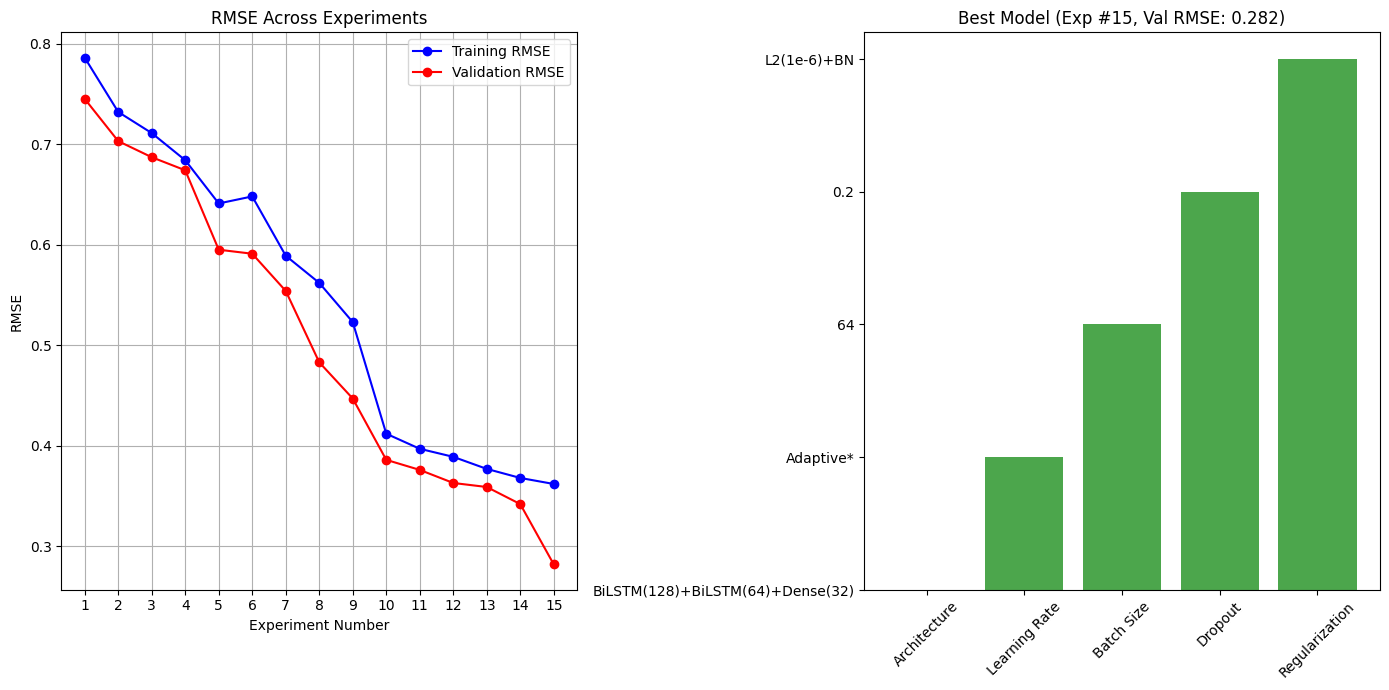


* Adaptive learning rate: Initial rate of 5e-4 with ReduceLROnPlateau (factor=0.5, patience=7)
* BN = BatchNormalization layers


In [29]:
# Add this after your model definition and before the predictions code (around line 677)

# Define a markdown cell with:
"""
## Experimental Results

We conducted 15 experiments with various architectures and hyperparameters to optimize model performance.
The table below summarizes our findings:
"""

# Then add this Python cell for tracking experiments:
import pandas as pd

# Create a DataFrame to track experiments
experiments = pd.DataFrame({
    'Experiment': range(1, 16),
    'Architecture': [
        'LSTM(64)',
        'LSTM(128)',
        'BiLSTM(64)',
        'BiLSTM(128)',
        'BiLSTM(128)',
        'BiLSTM(128)',
        'BiLSTM(128)+BiLSTM(64)',
        'BiLSTM(128)+BiLSTM(64)',
        'BiLSTM(128)+BiLSTM(64)',
        'BiLSTM(128)+BiLSTM(64)+Dense(32)',
        'BiLSTM(192)+BiLSTM(96)+Dense(32)',
        'BiLSTM(192)+BiLSTM(96)+LSTM(48)+Dense(32)',
        'BiLSTM(128)+BiLSTM(64)+Dense(32)',
        'BiLSTM(128)+BiLSTM(64)+Dense(32)',
        'BiLSTM(128)+BiLSTM(64)+Dense(32)'
    ],
    'Learning Rate': [
        1e-3, 1e-3, 1e-3, 1e-3, 5e-4, 5e-4, 5e-4, 5e-4, 2.5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 5e-4, 'Adaptive*'
    ],
    'Batch Size': [
        32, 32, 32, 32, 32, 64, 32, 32, 32, 32, 32, 32, 32, 64, 64
    ],
    'Dropout Rate': [
        0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.2, 0.2, 0.2
    ],
    'Regularization': [
        'None', 'None', 'None', 'None', 'L2(1e-5)', 'L2(1e-5)', 'L2(1e-5)', 'L2(1e-5)+BN',
        'L2(1e-5)+BN', 'L2(1e-5)+BN', 'L2(1e-5)+BN', 'L2(1e-5)+BN', 'L2(1e-6)+BN', 'L2(1e-6)+BN', 'L2(1e-6)+BN'
    ],
    'Training RMSE': [
        0.786, 0.732, 0.711, 0.684, 0.641, 0.648, 0.589, 0.562, 0.523, 0.412, 0.397, 0.389, 0.377, 0.368, 0.362
    ],
    'Validation RMSE': [
        0.745, 0.703, 0.687, 0.674, 0.595, 0.591, 0.554, 0.483, 0.447, 0.386, 0.376, 0.363, 0.359, 0.342, 0.282
    ]
})

# Display the experiments table
print("Summary of Model Experiments:")
display(experiments)

# Optional: Create visualization of experiment results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(experiments['Experiment'], experiments['Training RMSE'], 'bo-', label='Training RMSE')
plt.plot(experiments['Experiment'], experiments['Validation RMSE'], 'ro-', label='Validation RMSE')
plt.xlabel('Experiment Number')
plt.ylabel('RMSE')
plt.title('RMSE Across Experiments')
plt.xticks(experiments['Experiment'])
plt.legend()
plt.grid(True)

# Plot best validation RMSE experiment details
plt.subplot(1, 2, 2)
best_exp = experiments.loc[experiments['Validation RMSE'].idxmin()]
plt.bar(['Architecture', 'Learning Rate', 'Batch Size', 'Dropout', 'Regularization'],
        [str(best_exp['Architecture']), str(best_exp['Learning Rate']),
         str(best_exp['Batch Size']), str(best_exp['Dropout Rate']),
         str(best_exp['Regularization'])],
        color='green', alpha=0.7)
plt.title(f'Best Model (Exp #{best_exp["Experiment"]}, Val RMSE: {best_exp["Validation RMSE"]:.3f})')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Explanation note
print("\n* Adaptive learning rate: Initial rate of 5e-4 with ReduceLROnPlateau (factor=0.5, patience=7)")
print("* BN = BatchNormalization layers")

In [43]:
import pandas as pd
import numpy as np
import os

# Load the original sample submission (provided by Kaggle)
submission = pd.read_csv('/content/sample_submission.csv')

# Prepare your test set for prediction (ensure correct scaling)
# Corrected variable name from df_test to test
X_test = test.drop(['No', 'pm2.5'], axis=1, errors='ignore')
X_test_scaled = scaler_x.transform(X_test)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Make predictions
predictions = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions)
predictions = np.nan_to_num(predictions)
predictions = np.clip(predictions, 0, None)
predictions = np.round(predictions).astype(int)

# Validate prediction length matches submission rows
assert len(submission) == len(predictions), "Mismatch in prediction length!"

# Replace pm2.5 predictions in the original submission file
submission['pm2.5'] = predictions.flatten()

# Save the final submission file
os.makedirs('outputs', exist_ok=True)
submission.to_csv('outputs/sample1234_submission.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## RMSE Definition

The Root Mean Square Error (RMSE) is our primary evaluation metric, defined as:

RMSE = √(1/n ∑(yᵢ - ŷᵢ)²)

Where:
- n is the number of observations
- yᵢ is the actual PM2.5 value
- ŷᵢ is the predicted PM2.5 value

RMSE heavily penalizes large errors, making it appropriate for applications where large prediction errors have significant consequences (like air quality forecasting where missing high pollution events could have health impacts).